In [16]:
import pandas as pd
import json
from pandas import json_normalize
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph
from rdflib.namespace import FOAF, RDF

## MODELO DE LOS DATOS
La ontología-conferencia es una nueva ontología autónoma para modelar el conocimiento sobre las conferencias. La ontología de conferencia adopta las mejores prácticas de diseño de ontologías (p. ej., patrones de diseño de ontologías, reutilización e interconexión de ontologías) y garantiza la interoperabilidad con la ontología SWC y todos los demás vocabularios pertinentes.

![title](capturas/model.png)

## DIMENSIONAMIENTO DE LOS DATOS RDF

Para cada Query elaborada en el siguiente Notebook se los ha obtenido de nuestro almacenamiento local de GraphDB es por esto que el endpoint de consulta es variable, el conjunto de datos fue descargado mediante funciones wget del volcado de datos de **Scholarly Data** correspondiente a papers de conferencias.

### Obtención de la dimensión o cantidad de clases que existen

In [17]:
#endPoint = "http://MSI:7200/repositories/ProyectoDatos"
endPoint = "http://DESKTOP-3KNOEN3:7200/repositories/PROYECTO"

sparql = SPARQLWrapper(endPoint)

def getClassesDimention():
    query = """
    PREFIX person: <https://w3id.org/scholarlydata/person/>
    PREFIX conf: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>
    SELECT DISTINCT ?class (count(?class) as ?count)
    WHERE{
     [ ] a ?class.
    
        FILTER(regex(str(?class), 'https://w3id.org/scholarlydata/ontology/conference-ontology.owl#', 'i')) 

    }GROUP BY ?class
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getClassesDimention()
df = json_normalize(results["results"]["bindings"]) #Res



In [4]:
df['class'] = df['class.value'].str.lstrip('https://w3id.org/scholarlydata/ontology/conference-ontology.owl#')
df = df[['class', 'count.value']]


Los **ListItem** corresponden a elementos de una lista especificamente autores de un paper, por ejemplo si en un paper existe unicamente un autor este se encontrará en la primera posición de la lista.

Los **InProceedings** hacen referencia a los papers publicados.

<class 'numpy.int32'>


2022-01-28 07:57:58,972 [26588] WARNING  py.warnings:110: [JupyterRequire] c:\users\juanj\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)



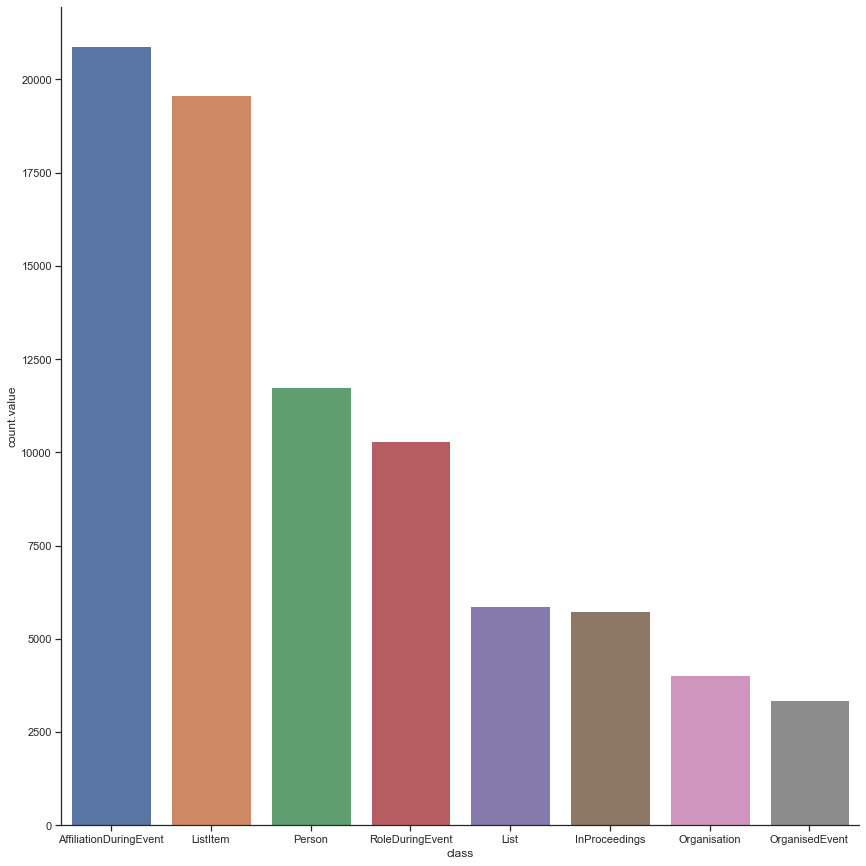

In [5]:
df['count.value'] = df['count.value'].astype(int)
print(type(df["count.value"][0]))
df = df.sort_values('count.value',ascending=False).head(8)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

sns.catplot(x="class", y="count.value", kind="bar", data=df, size=12)


### Cantidad de propiedades que existen en la Ontologia

In [6]:
def getPropertiesDimention():
    query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX person: <https://w3id.org/scholarlydata/person/>
    PREFIX conf: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>

    SELECT DISTINCT ?prop (count(*) AS ?count)
        WHERE {
            ?prop a rdf:Property.
            [] ?prop ?object.
        }group by ?prop
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getPropertiesDimention()
df2 = json_normalize(results["results"]["bindings"]) #Res


In [7]:
from urllib.parse import urlparse
for index, row in df2.iterrows():
    row['prop.value'] = urlparse(row['prop.value']).fragment
    row['count.value'] = int(row['count.value'])

df2 = df2[['prop.value', 'count.value']]
df2 = df2.sort_values('count.value',ascending=False).head(7)
df2

,prop.value,count.value
0,type,82383
8,label,35669
26,during,31314
5,sameAs,23394
24,isAffiliationOf,20903
25,withOrganisation,20903
23,hasAffiliation,20903


<AxesSubplot:ylabel='count.value'>

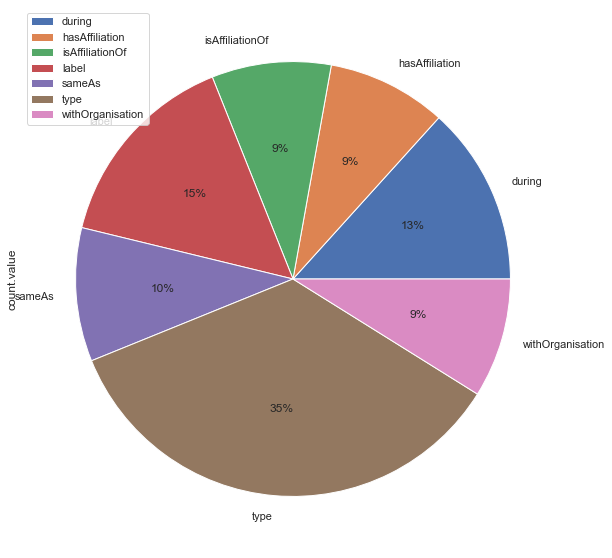

In [8]:
df2.groupby(['prop.value']).sum().plot(kind='pie', y='count.value', autopct='%1.0f%%', figsize=(10,10))

## ¿Que Papers conllevan más autores?

In [9]:
def getPapers():
    query = """
    PREFIX person: <https://w3id.org/scholarlydata/person/>
    PREFIX conf: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>
    SELECT DISTINCT ?paper ?title ?person ?name ?doi
    WHERE{
      ?paper a conf:InProceedings;
        conf:hasAuthorList ?authorList;
        conf:title ?title .
      ?authorList conf:hasFirstItem ?item .
      ?item conf:hasContent ?person .
      ?person conf:name ?name
    }
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getPapers()
df3 = json_normalize(results["results"]["bindings"]) #Res
df3 = df3[['paper.value','title.value', 'name.value']]
df3

,paper.value,title.value,name.value
0,https://w3id.org/scholarlydata/inproceedings/c...,Identifying Information Needs by Modelling Col...,Khadija Elbedweihy
1,https://w3id.org/scholarlydata/inproceedings/c...,Incremental SPARQL Evaluation for Query Answer...,Florian Schmedding
2,https://w3id.org/scholarlydata/inproceedings/c...,LODWheel – JavaScript-based Visualization of R...,Magnus Stuhr
3,https://w3id.org/scholarlydata/inproceedings/c...,The Information Workbench as a Self-Service Pl...,Peter Haase
4,https://w3id.org/scholarlydata/inproceedings/c...,Towards Green Linked Data,Julia Hoxha
...,...,...,...
6170,https://w3id.org/scholarlydata/inproceedings/x...,Extraction of Onomatopoeia Used for Foods from...,Ayumi Kato
6171,https://w3id.org/scholarlydata/inproceedings/x...,Solution Mining for specific contextualised pr...,Christian Severin Sauer
6172,https://w3id.org/scholarlydata/inproceedings/x...,Extraction of procedural knowledge from the We...,Pol Schumacher
6173,https://w3id.org/scholarlydata/inproceedings/x...,"Collecting, reusing and executing private work...",Sebastian Görg


In [10]:
df3['name'] = df3['name.value'] 
p = df3.groupby('title.value').name.nunique().reset_index()
print(p.sort_values(by=['name'], ascending=False))

                                            title.value  name
4491  Summary Models for Routing Keywords to Linked ...     7
2354  IBSE: An OWL Interoperability Evaluation Infra...     6
4731     The Object with States Ontology Design Pattern     6
2236  Guidelines for Benchmarking the Performance of...     6
3384  Ontology-based Interpretation of Keywords for ...     5
...                                                 ...   ...
1909  Exploring Semantic Features for Producing Top-...     1
1908             Exploring Scholarly Data with Rexplore     1
1907                Exploring RDF/S KBs Using Summaries     1
1906         Exploring Linked Open Data with Tag Clouds     1
5495  ♠ Demo: An Open Source Tool for Partial Parsin...     1

[5496 rows x 2 columns]


## Papers relacionados con SPARQL o RDF

### Parametrización de titulos de papers / aplicación de filtros

In [14]:
cond = True
entrada = ''
filtros = ''
while(cond == True):
    print('Ingrese caracteres de busqueda')
    entrada = input("->")
    filtros = "%s'%s' " % (filtros, entrada)
    print('¿Desea ingresar otro caracter? S/N')
    op = input('->')
    if (op == 'n' or op == 'N'):
        cond = False
        
print(filtros)

Ingrese caracteres de busqueda
->SPARQL
¿Desea ingresar otro caracter? S/N
->S
Ingrese caracteres de busqueda
->RDF
¿Desea ingresar otro caracter? S/N
->N
'SPARQL' 'RDF' 


In [18]:
def getPapers():
    query = """
    PREFIX person: <https://w3id.org/scholarlydata/person/>
    PREFIX conf: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>
    SELECT DISTINCT ?paper ?title ?abstract
    WHERE{
       VALUES ?tipoPaper{%s}
      ?paper a conf:InProceedings;
        conf:hasAuthorList ?authorList;
        conf:title ?title;
        conf:abstract ?abstract. 
       filter contains(UCASE(?title), ?tipoPaper) 
    }
    """ % (filtros)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getPapers()
df4 = json_normalize(results["results"]["bindings"]) #Res
df4 = df4[['paper.value', 'title.value','abstract.value']]
df4

,paper.value,title.value,abstract.value
0,https://w3id.org/scholarlydata/inproceedings/e...,Freshening Up While Staying Fast: Towards Hybr...,Linked Data querying over cached indexes of We...
1,https://w3id.org/scholarlydata/inproceedings/e...,Vocabulary Services Based on SPARQL Endpoints:...,Vocabularies are an integral part of Linked Da...
2,https://w3id.org/scholarlydata/inproceedings/e...,Flexible RDF generation from RDF and heterogen...,RDF aims at being the universal abstract data ...
3,https://w3id.org/scholarlydata/inproceedings/e...,Extraction and Visualization of TBox Informati...,The growing amount of data being published as ...
4,https://w3id.org/scholarlydata/inproceedings/e...,An Evolutionary Algorithm to Learn SPARQL Quer...,Efficient usage of the knowledge provided by t...
...,...,...,...
382,https://w3id.org/scholarlydata/inproceedings/w...,D2RQ/Update: Updating Relational Data via Virt...,D2RQ is a popular RDB-to-RDF mapping platform ...
383,https://w3id.org/scholarlydata/inproceedings/w...,On Directly Mapping Relational Databases to RD...,Mapping relational databases to RDF is a funda...
384,https://w3id.org/scholarlydata/inproceedings/w...,Getting More RDF Support from Relational Datab...,"We introduce the database fragment of RDF, whi..."
385,https://w3id.org/scholarlydata/inproceedings/w...,"Binary RDF for Scalable Publishing, Exchanging...",The Web of Data is producing increasingly larg...


## Cantidad de eventos que se dieron en determinadas localizaciones

In [12]:
def getEvents():
    query = """
    PREFIX cofunc: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    SELECT DISTINCT ?event ?nameEvent ?loc ?desc 
        WHERE {
            ?event a cofunc:OrganisedEvent;
            rdfs:label ?nameEvent;
            cofunc:description ?desc;
            cofunc:location ?loc;
            }
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getEvents()
df5 = json_normalize(results["results"]["bindings"]) #Res
df5['event'] = df5['event.value']

q = df5.groupby('loc.value').event.nunique().reset_index()
q1 = q.sort_values('event',ascending=False).head(5)
print(q1)

        loc.value  event
19  Mediteranea 2     20
4        Aurora 1     18
0     098 260.098     17
14        Emerald     16
18  Mediteranea 1     15


<AxesSubplot:ylabel='event'>

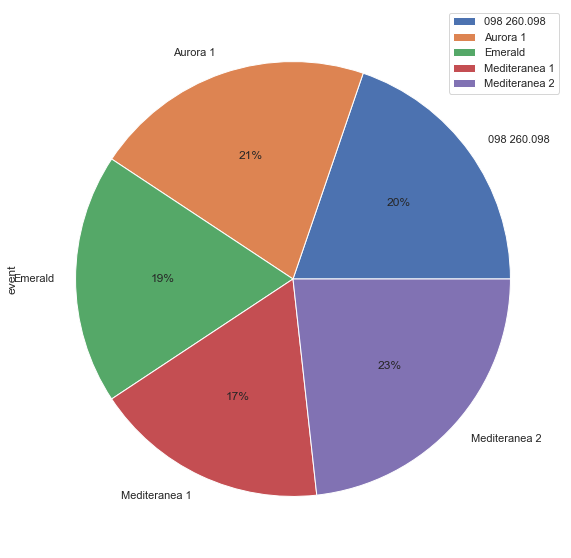

In [13]:
q1.groupby(['loc.value']).sum().plot(kind='pie', y='event', autopct='%1.0f%%', figsize=(10,10))

### Obtener anotaciones del Abstract mediante dbpedia Spotlight 

Con un enfoque de cuatro pasos, Dbpedia Spotlight realiza la extracción de entidades con nombre, incluida la detección de entidades y la resolución de nombres. También se puede utilizar para el reconocimiento de entidades con nombre, entre otras tareas de extracción de información.

In [18]:
import spotlight 
from functools import partial

endpoint = 'https://api.dbpedia-spotlight.org/en/'


text = df4['abstract.value'][0]

def getAnnotations(text, confidence=0.4, support=20):
    
    annotations = spotlight.annotate(endpoint + 'annotate', text, confidence=confidence, support=support)
    listAnn = []
    for a in annotations:
        listAnn.append([a['URI'], a['support'], a['types'], a['surfaceForm'], a['similarityScore']])
    return listAnn

print(getAnnotations(text))

[['http://dbpedia.org/resource/Linked_data', 256, '', 'Linked Data', 1.0], ['http://dbpedia.org/resource/Cache_coherence', 182, '', 'cached', 0.9998825725527143], ['http://dbpedia.org/resource/Runtime_system', 446, '', 'runtime', 0.9999992261688969], ['http://dbpedia.org/resource/Hybrid_electric_vehicle', 1356, '', 'hybrid', 0.8955368841098621], ['http://dbpedia.org/resource/Linked_data', 256, '', 'Linked Data', 1.0], ['http://dbpedia.org/resource/Hybrid_electric_vehicle', 1356, '', 'hybrid', 0.8955368841098621], ['http://dbpedia.org/resource/Cache_coherence', 182, '', 'cached', 0.9998825725527143], ['http://dbpedia.org/resource/Black_box', 323, '', 'black boxes', 0.9999999892345387], ['http://dbpedia.org/resource/Hybrid_electric_vehicle', 1356, '', 'hybrid', 0.8955368841098621], ['http://dbpedia.org/resource/Cache_coherence', 182, '', 'cached', 0.9998825725527143], ['http://dbpedia.org/resource/Linked_data', 256, '', 'Linked Data', 1.0]]


Para poder trabajarlos junto a DBpediaSpotlight la estructura de listaPapersAnnotations es  **[URI DEL PAPER, [LISTA DE ANOTACIONES DEL PAPER]]** De esta manera cada anotación se asociará a un paper en particular en este caso su identificador es la URI

In [22]:
listaPapersAnnotations = []
for index, row in df4.iterrows():
    #getAnnotations(row['abstract.value'])
    listaPapersAnnotations.append([row['paper.value'], getAnnotations(row['abstract.value'])])
    print(row['abstract.value'])

Linked Data querying over cached indexes of Web data often suffers from stale or missing results due to infrequent updates and partial coverage of available sources. Conversely, live decentralised approaches offer fresh results taken directly from the Web, but suffer from slow response times due to the expense of numerous remote lookups at runtime. We thus propose a hybrid query approach that improves upon both paradigms, offering fresher results from a broader range of sources than Linked Data caches while offering faster results than live querying. Our hybrid query engine takes a cached and live query engine as black boxes, where a hybrid query planner splits an input query and delegates the appropriate sub-queries to each interface. In this paper, we discuss the core query-planning issues and their main strengths and weaknesses. We also present coherence measures to quantify the coverage and freshness for cached indexes of Linked Data, and show how these measures can be used during 

This research explores our novel method for Semantic Web service matchmaking based on iSPARQL queries, which enable the user to query the Semantic Web with techniques from traditional information retrieval. The strategies for matchmaking which we develop and evaluate in the paper make use of a plethora of similarity measures and combination functions from SimPack -- our library of similarity measures for the use in ontologies. We show how our combination of structured and imprecise querying can be used to perform hybrid Semantic Web service matchmaking in simple and amazingly fast fashion. We analyze our approach thoroughly on a large OWL-S service test collection, and show how our initial strategies can be improved by applying machine learning algorithms such as regression, decision trees, or support vector machines to result in the most effective strategies for matchmaking.
Integrated access to multiple distributed and autonomous RDF data sources is a key challenge for many semantic 

RDF is the metadata model of choice in the Semantic Sensor Web. However, RDF can only represent thematic metadata and needs to be extended if we want to model spatial and temporal information. For this purpose, we develop the data model stRDF and the query language stSPARQL. stRDF is a constraint data model that extends RDF with the ability to represent spatial and temporal data. stSPARQL extends SPARQL so that spatial and temporal data can be queried using a declarative and user-friendly language. We follow the main ideas of spatial and temporal constraint databases and represent spatial objects as quantifier-free formulas in a first-order logic of linear constraints. The main contribution of stRDF is to bring to the RDF world the benefits of constraint databases and constraint-based reasoning so that spatial and temporal data can be represented in RDF using constraints. In this paper, we present the syntax and semantics of stRDF and stSPARQL and discuss some details of our in-progres

Publicly available Linked Data repositories provide a multitude of information. By utilizing SPARQL, Web sites and services can consume this data and present it in a user-friendly form, e.g., in mash-ups. To gather RDF triples for this task, machine agents typically issue similarly structured queries with recurring patterns against the SPARQL endpoint. These queries usually differ only in a small number of individual triple pattern parts, such as resource labels or literals in objects. We present an approach to detect such recurring patterns in queries and introduce the notion of query templates, which represent clusters of similar queries exhibiting these recurrences. We describe a matching algorithm to extract query templates and illustrate the benefits of prefetching data by utilizing these templates. Finally, we comment on the applicability of our approach using results from real-world SPARQL query logs.
In this paper we introduce Spartiqulation, a system that translates SPARQL que

The discovery of optimal or close to optimal query plans for SPARQL queries is a difficult and challenging problem for query optimisers of RDF engines. Despite the growing volume of work on optimising SPARQL query answering, using heuristics or data statistics (such as cardinality estimations) there is little effort on the use of OWL constructs for query optimisation. OWL axioms can be the basis for the development of schema-aware optimisation techniques that will allow significant improvements in the performance of RDF query engines when used in tandem with data statistics or other heuristics. The aim of this paper is to show the potential of this idea, by discussing a diverse set of cases that depict how schema information can assist SPARQL query optimisers.
In the Resource Description Framework, literals are composed of a UNICODE string (the lexical form), a datatype IRI, and optionally, when the datatype IRI is rdf:langString, a language tag. Any IRI can take the place of a datatyp

DBpedia crystallized most of the concepts of the Semantic Web using simple mappings to convert Wikipedia articles to RDF data. This ``semantic view'' of wiki content has rapidly become the focal point of the Linked Open Data cloud, but its impact on the original Wikipedia source is limited. In particular, little attention has been paid to the benefits that the semantic infrastructure can bring to maintain the wiki content, for instance to ensure that the effects of a wiki edit are consistent across infoboxes. In this paper, we present an framework for handling ontology-based updates of wiki content. Starting from DBpedia-like mappings converting infoboxes to a fragment of {tt OWL 2 RL} ontology, we discuss various issues associated with translating SPARQL updates on top of semantic data to the underlying Wiki content. On the one hand, we provide a formalization of DBpedia as an Ontology Based Data Management framework and study its computational properties. On the other hand, we provid

SPARQL lowers the barrier to RDF-based mashup development. It does, however, not support write operations, useful constructs like aggregates, the ability to combine and post-process query results, or human-oriented result formats. This paper describes a set of extensions that largely reuse SPARQL's intuitive syntax to provide query aggregates and update functionality (SPARQL+), result processing and chained queries across multiple endpoints (SPARQLScript), and result templating. The combination of these extensions enables the creation of mashups not only from distributed data sources, but also from portable application components.
This short demo description presents an extension to the Konduit tool for visual programming for the semantic desktop. Previously, Konduit required users to define filter components by manually specifying a SPARQL CONSTRUCT query. With the current work presented in this demo, we are exploring ways of building such queries visually, and aiding the use in doing

We extend the Semantic Web query language SPARQL by defining the semantics of SPARQL queries under the entailment regimes of RDF, RDFS, and OWL. The proposed extensions are part of the SPARQL 1.1 Entailment Regimes working draft which is currently being developed as part of the W3C standardization process of SPARQL 1.1. We review the conditions that SPARQL imposes on such extensions, discuss the practical difficulties of this task, and explicate the design choices underlying our proposals. In addition, we include an overview of current implementations and their underlying techniques.
The Semantic Web is now gaining momentum due to its efforts to create a universal medium for the exchange of semantically tagged data. The representation and querying of semantic data have been made by means of directed labelled graphs using RDF and SPARQL, standards which have been widely accepted by the scientific community. Currently, most implementations of RDF/SPARQL are based on relational database t

The distributed and heterogeneous nature of Linked Open Data requires flexible and federated techniques for query evaluation. In order to evaluate current federation querying approaches a general methodology for conducting benchmarks is mandatory. In this paper, we present a classification methodology for federated SPARQL queries. This methodology can be used by developers of federated querying approaches to compose a set of test benchmarks that cover diverse characteristics of different queries and allows for comparability. We further develop a heuristic called SPLODGE for automatic generation of benchmark queries that is based on this methodology and takes into account the number of sources to be queried and several complexity parameters. We evaluate the adequacy of our methodology and the query generation strategy by applying them on the 2011 billion triple challenge data set.
We describe a system that incrementally translates SPARQL queries to Pig Latin and executes them on a Hadoo

Formal concept analysis (FCA) is used for knowledge discovery within data. In FCA, concept lattices are very good tools for classification and organization of data, hence, they enable the user to visualize the answers of its SPARQL query as concept lattices instead of the usual answer formats such as: RDF/XML,  JSON, CSV,  and HTML. Consequently, in this work,  we apply FCA to reveal hidden relations within SPARQL query answers by means of concept lattices.
Combining structured queries with full-text search provides a powerful means to access distributed linked data. However, executing hybrid search queries in a federation of multiple data sources presents a number of challenges due to data source heterogeneity and lack of statistical data about keyword selectivity. To address these challenges, we present FedSearch – a novel hybrid query engine based on the SPARQL federation framework FedX. We extend the SPARQL algebra to incorporate keyword search clauses as ﬁrst-class citizens and ap

In this paper, we present an empirical comparison of user performance and perceived usability for Sparql versus SemwidgQL, a path-oriented RDF query language. We developed SemwidgQL to facilitate the formulation of RDF queries and to enable non-specialist developers andWeb authors to integrate Linked Data and other semantic data sources into standard Web applications. We performed a user study in which participants wrote a set of queries in both languages.We measured both objective performance as well as subjective responses to a set of questionnaire items. Results indicate that SemwidgQL is easier to learn, more efficient, and preferred by learners. To assess the applicability of SemwidgQL in real applications, we analyzed its expressiveness based on a large corpus of observed Sparql queries, showing that the language covers more than 90% of the typical queries performed on Linked Data.
Answering queries over a federation of SPARQL endpoints requires combining data from more than one 

In this demo paper, we present the interface of the SQCFrameWork, a SPARQL query containment benchmark generation framework. SQCFrameWork is able to generate customized SPARQL containment benchmarks from real SPARQL query logs. To this end, the framework makes use of the different clustering techniques. It is flexible enough to generate benchmarks of varying sizes and complexities according to user-defined criteria on important SPARQL features for query containment benchmarking. We evaluate the usability of the interface by using the standard system usability scale questionnaire. Our overall usability score of 82.33 suggests that the online interface is consistent, easy to use, and the various functions of the system are well integrated. 
Sometimes one does not want all the solutions to a query but instead only
those that are most desirable according to user-specified preferences.  If a
user-specified preference relation is acyclic then its specification and
meaning are straightforward

Despite the growing popularity of knowledge graphs for managing diverse data at large scale, users who wish to pose expressive queries against such graphs are often expected to know (i) how to formulate queries in a language such as SPARQL, and (ii) how entities of interest are described in the graph. In this paper we propose a language that relaxes these expectations; the language's operators are based on an interactive graph-based exploration that allows non-expert users to simultaneously navigate and query knowledge graphs; we compare the expressivity of this language with SPARQL. We then discuss an implementation of this language that we call RDF Explorer and discuss various desirable properties it has, such as avoiding interactions that lead to empty results. Through a variety of user studies over the Wikidata knowledge-graph, we show that users successfully complete more tasks with RDF Explorer than with the existing Wikidata Query Helper, where a usability questionnaire demonstr

The availability of linked RDF data remains a significant barrier to the realisation of a Semantic Web. In this paper we present SparqPlug, a framework that uses the SPARQL query language and the HTML Document Object Model to convert legacy HTML-only data sets into RDF. This approach improves upon existing approaches in a number of ways. For example, it allows HTML data to be queried using the full flexibility of SPARQL and makes converted data automatically available in the Semantic Web. We outline the process of mass generation of RDF from HTML using SparqPlug and illustrate this with a case study. The paper concludes with an examination of factors affecting SparqPlug's performance across various forms of HTML data.
Many Semantic Web applications require the integration of data from distributed and autonomous RDF data sources. However, the values in the RDF triples would be frequently recorded simply as the literal, and additional contextual information such as unit and format is oft

C-SPARQL is an extension of SPARQL to support continuous queries over RDF data streams. Supporting streams in RDF format guarantees interoperability and opens up important applications, in which reasoners can deal with knowledge that evolves over time. We present C-SPARQL by means of examples in Urban Computing.
Streams of events appear increasingly today in various Web applications such as blogs, feeds, sensor data streams, geospatial information, on-line financial data, etc. Event Processing (EP) is concerned with timely detection of compound events within streams of simple events. State-of-the-art EP provides on-the-fly analysis of event streams, but cannot combine streams with background knowledge and cannot perform reasoning tasks. On the other hand, semantic tools can effectively handle background knowledge and perform reasoning thereon, but cannot deal with rapidly changing data provided by event streams. To bridge the gap, we propose Event Processing SPARQL (EP-SPARQL) as a new

Information retrieval on RDF data benefits greatly from additional provenance information attached to the individual pieces of information. Currently, provenance information such as source, certainty, and temporal information on RDF statements can be used to rank search results according to one of those dimensions. In this paper, we consider the problem of aggregating provenance information from different dimensions in order to obtain a joint ranking over all dimensions. We relate this problem to the problem of preference aggregation in social choice theory and translate different solutions for preference aggregation to the problem of aggregating provenance rankings. By exploiting the algebraic structure of provenance rankings we characterize three different approaches for aggregating preferences, namely the lexicographical rule, the Borda rule and the plurality rule, in our framework of provenance aggregation.
  Expressions, such as mathematical formulae, logical axioms, or
  structur

This paper presents a minimalist program for RDF, by showing
 how one can do without several predicates and keywords of the 
 RDF Schema vocabulary, obtaining a simpler language which 
 preserves the original semantics. This approach is beneficial
 in at least two directions:
 (a) To have a simple abstract fragment of RDFS easy to formalize
 and to reason about, which captures the essence of RDFS;
 (b) To  obtain algorithmic properties of deduction
 and optimizations that are relevant for particular fragments.
   Among our results are: the identification of a simple fragment 
 of RDFS; the proof that it encompasses the main features of
 RDFS; a formal semantics and a deductive system for it;
 sound and complete deductive systems for their sub-fragments;
 and an O(n log n) complexity bound for ground entailment in 
 this fragment.
This paper presents a framework for the reuse and extension of existing, established vocabularies in the Semantic Web. Driven by the primary application of ex

The use of natural language identiﬁers as reference for ontology elements—in addition to the URIs required by the Semantic Web standards—is of utmost importance based on their predominance in the human everyday life, i.e. speech or print media. Depending on the context, different names can be chosen for one and the same element, and the same element can be referenced by different names. Here homonymy and synonymy are the main cause of the appearance of ambiguity in perceiving which concrete unique ontology element ought to be referenced by a speciﬁc natural language identiﬁer describing an entity. We propose a novel method to resolve entity references under the aspect of ambiguity which explores only formal background knowledge represented in RDF graph structures. The key idea of our domain independent approach is to build an entity network with the most likely referenced ontology elements by constructing spanning graphs based on spreading activation (SA). Additional to the exploitatio

This paper presents Grr, a powerful system for generating random RDF data, which can be used to test Semantic Web applications. Grr has a SPARQL-like syntax, which allows the system to be both powerful and convenient.  It is shown that Grr can  easily be used to produce intricate datasets, such as the LUBM benchmark. Optimization techniques are employed, which make the generation process efficient and scalable.
There is a comprehensive body of theory studying updates and schema evolution of Knowledge bases, ontologies, and in particular of RDFS.  In this paper we turn these ideas into practice by presenting a feasible and practical procedure for updating RDFS. Along the lines of ontology evolution, we treat schema and instance updates separately, showing that RDFS instance updates are not only feasible, but also deterministic. For RDFS schema update, known to be untractable in the general abstract case, we show that it   becomes feasible in  real world datasets. We present for both, in

Information on the temporal interval of validity for facts described by RDF triples         plays an important role in a large number of applications. Yet, most of the knowledge bases         available on the Web of Data do not provide such information in an explicit manner. In this         paper, we present a generic approach which addresses this drawback by inserting temporal         information into knowledge bases. Our approach combines two types of information to         associate RDF triples with time intervals. First, it relies on temporal information gathered         from the document Web by an extension of the fact validation framework DeFacto. Second, it         harnesses the time information contained in knowledge bases. This knowledge is combined         within a three-step approach which comprises the steps matching, selection and merging. We         evaluate our approach against a corpus of facts gathered from Yago2 by using DBpedia and         Freebase as input and diffe

Indented tree has been widely used to organize information and visualize graph-structured data like RDF graphs. Given a starting resource in a cyclic RDF graph, there are different ways of transforming the graph into a tree representation to be visualized as an indented tree. It would be interesting to investigate whether and how these different representations influence the user's browsing experience. In this paper, we address this issue from the coherence aspect of tree representation. We aim to smooth the user's reading experience by visualizing an optimal indented tree in the sense of featuring the fewest reversed edges, which often cause confusion and interrupt the user's cognitive process due to lack of a general, effective way of presentation. To achieve this, we propose a two-step approach that is theoretically proved to generate such an optimal tree representation for a given RDF graph and a specified starting resource. We also empirically show the difference in coherence betw

Existing interlinking tools focus on finding similarity relationships between entities of distinct RDF datasets by generating owl:sameAs links.
These approaches address the detection of equivalence relations between entities. However, in some contexts, more complex relations are required, and the links to be defined follow more sophisticated patterns.
This paper introduces Link++, an approach that enables the discovery of complex links in a flexible manner.
Link++ enables the users to generate rich links by defining custom functions and linking patterns that fit their needs.
AutoRDF is an original open source framework that facilitates handling RDF data from a software engineering point of view. Built on top of the Redland software package, it bridges the gap between semantic web ontology and legacy object oriented languages, by providing transparent access to RDF resources from within standard C++ objects.
Its use of widespread C++11, Boost and Redland makes it suitable not only for t

The Linked Data (LD) initiative fostered the publication of a large number of relational databases in the Linked Open Data (LOD) cloud. A general and flex-ible way of publishing relational data in RDF format is to create an RDB-RDF view, that is, an RDF view of the underlying relational data. An RDB-RDF view can be materialized to improve query performance and data availability. However, an RDB-RDF view must be continuously maintained to reflect dynamic updates over the relational database. The contents of an RDB-RDF view, published on the LOD cloud, can also be fully or partially replicated by other LD applications to improve their efficiency. Thus, updates on an RDB-RDF view must be propagated to maintain other LD application views. This pa-per proposes This paper proposes a framework, based on rule, for providing live synchronization of RDB_RDF view. In the proposed framework, rules are re-sponsible for computing and publish the changeset required for the RDB-RDF view to stay in syn

The Semantic Web community has successfully contributed to a remarkable number of RDF data published on the Web.
However, to use and build applications on top of Linked Data is still a cumbersome and time demanding task.
We present KBox, an open-source platform that facilitates the distribution and consumption of RDF data.
We show the different APIs implemented by KBox as well as the processing steps from an SPARQL query to its corresponding result.
Additionally, we demonstrate how KBox can be used to share RDF knowledge graphs as well as to instantiate SPARQL endpoints.
The number of sensors producing data streams at a high velocity keeps increasing. This paper describes an attempt to design an inference-enabled, distributed, fault-tolerant framework targeting RDF streams. Our solution gives a special attention to the latency issue, an important feature in the context of providing reasoning services. Low latency is attained by compressing the scheme and data of processed streams with 

The ability to compute the differences that exist between two RDF models is an important step to cope with the evolving nature of the Semantic Web (SW). In particular, RDF Deltas can be employed to reduce the amount of data that need to be exchanged and managed over the network and hence build advanced SW synchronization and versioning services. By considering Deltas as sets of change operations, in this paper we study various RDF comparison functions in conjunction with the semantics of the underlying change operations and formally analyze their possible combinations in terms of correctness, minimality, semantic identity and redundancy properties.
We study the continuous evaluation of conjunctive triple pattern queries over RDF data stored in distributed hash tables. In a continuous query scenario network nodes subscribe with long-standing queries and receive answers whenever RDF triples satisfying their queries are published. We present two novel query processing algorithms for this 

Despite the increasing popularity of RDF as a data  representation method, there is no accepted measure of the  importance of nodes in an RDF graph. Such a measure could be used to  sort the nodes returned by a SPARQL query or to find the important  concepts in an RDF graph. In this paper we propose a graph-theoretic  measure called noc-order for ranking nodes in RDF graphs based  on the notion of centrality. We illustrate that this method is able  to capture interesting global properties of the underlying RDF graph  using study cases from different knowledge domains. We also show how  well noc-order behaves even if the underlying data has some noise,  i.e. superfluous and/or erroneous data. Finally, we discuss how  information about the importance of different predicates either  based on their informativeness, prior semantic information about  them or user preferences can be incorporated into this measure. We  show the effects of such modifications to the ranking method by  examples.


RDF is an increasingly important paradigm for the representation of information on the Web. As RDF databases increase in size to approach tens of millions of triples, and as sophisticated graph matching queries expressible in languages like SPARQL become increasingly important, scalability becomes an issue. To date, there is no graph-based indexing method for RDF data where the index was designed in a way that makes it disk-resident. There is therefore a growing need for indexes that can operate efficiently when the index itself resides on disk. In this paper, we first propose the DOGMA index for fast subgraph matching on disk and then develop a basic algorithm to answer queries over this index. This algorithm is then significantly sped up via an optimized algorithm that uses efficient (but correct) pruning strategies when combined with two different extensions of the index. We have implemented a preliminary system and tested it against four existing RDF database systems developed by o

Adopting keyword query interface to semantic search on RDF data can help users keep away from learning the SPARQL query syntax and understanding the complex and fast evolving data schema. The existing approaches are divided into two categories: instance-based approaches and schema-based approaches. The instance-based approaches relying on the original RDF graph can generate precise answers but take a long processing time. In contrast, the schema-based approaches relying on the reduced summary graph require much less processing time but cannot always generate correct answers. In this paper, we propose a novel approach based on a hybrid graph which can achieve significant improvements on processing time with a limited accuracy drop compared with instance-based approaches, and meanwhile, can achieve promising accuracy gains at an affordable time cost compared with schema-based approaches.
Smartphones are becoming main personal information repositories. Unfortunately this information is st

RDF(S) and OWL 2 currently support only static ontologies. In practice, however, the truth of statements often changes with time, and Semantic Web applications often need to represent such changes and reason about them. In this paper we present a logic-based approach for representing validity time in RDF and OWL. Unlike the existing proposals, our approach is applicable to entailment relations that are not deterministic, such as the Direct Semantics or the RDF-Based Semantics of OWL 2.We also extend SPARQL to temporal RDF graphs and present a query evaluation algorithm. Finally, we present an optimization of our algorithm that is applicable to entailment relations characterized by a set of deterministic rules, such RDF(S) and OWL 2 RL/RDF entailment.
Although it appears that reasoning in RDFS is embarrassingly parallel, this is not the case. Because all vocabulary is treated the same way in RDF, it is possible to extend the RDFS ontology vocabulary. The ability permits the creation of 

This poster proposes a minimal, backward compatible and combinable restful interface for RDF Stream Engine.
As a massive linked open data is available in RDF, the scalable storage and efficient retrieval using MapReduce have been actively studied. Most of previous researches focus on reducing the number of MapReduce jobs for processing join operations in SPARQL queries. However, the cost of shuffle phase still occurs due to their reduce-side joins. In this paper, we propose RDFChain which supports the scalable storage and efficient retrieval of a large volume of RDF data using a combination of MapReduce and HBase which is NoSQL storage system. Since the proposed storage schema of RDFChain reflects all the possible join patterns of queries, it provides a reduced number of storage accesses depending on the join pattern of a query. In addition, the proposed cost-based map-side join of RDFChain reduces the number of map jobs since it processes as many joins as possible in a map job using s

Containers - lightweight, stand-alone software executables - are everywhere.
Industries exploit container managers to orchestrate complex cloud infrastructures
and researchers in academia use them to foster reproducibility of computational experiments.
Among existing solutions, Docker is the de facto standard in the container industry.
In this paper, we advocate the value of applying the Linked Data paradigm to the container ecosystem’s building scripts,
as it will allow adding additional knowledge, ease decentralized references, and foster interoperability.
In particular we defined a vocabulary Dockeronto that allows to semantically annotate Dockerfiles.
In many applications, there is an increasing need for the new types of RDF data analysis that are not covered by standard reasoning tasks such as SPARQL query answering. One such important analysis task is entity comparison, i.e., determining what are similarities and differences between two given entities in an RDF graph.
For instanc

Vector space embeddings have been shown to perform well when using RDF data in data mining and machine learning tasks. Existing approaches, such as RDF2vec, use local techniques, i.e., they rely on local sequences generated for nodes in the RDF graph. For word embeddings, global techniques, such as GloVe, have been proposed as a better performing alternative. In this paper, we show how the idea of global embeddings can be transferred to RDF embeddings, and demonstrate that in quite a few scenarios, better results than with local embeddings can be achieved.
In this paper, we leverage advances in the Semantic Web area, e.g., data modeling (RDF), data management and querying (JENA and SPARQL), to develop CodeOntology, a community shared software framework supporting expressive queries over source code. The project consists of two main contributions: an ontology that provides a  formal representation of object-oriented programming languages, and a parser that is able to analyze Java source

Reference lists from academic articles are core elements of scholarly communication that permit the attribution of credit and integrate our independent research endeavours. Hitherto, however, they have not been freely available in an appropriate machine-readable format such as RDF and in aggregate for use by scholars. To address this issue, one year ago we started ingesting citation data from the Open Access literature into the OpenCitations Corpus (OCC), creating an RDF dataset of scholarly citation data that is open to all. In this paper we introduce the OCC and we discuss its outcomes and uses after the first year of life.
In StreamReasoning (SR),  empirical research on RDF Stream Processing (RSP) is attracting a growing attention. 
The SR community proposed methodologies and benchmarks to investigate the RSP solution space and improve existing approaches. 
In this paper, we present rsplab, an infrastructure that reduces the effort required to design and execute reproducible experim

Ontology Summarization aspires to produce an abridged version of the original data source highlighting its most important concepts. However, in an ideal scenario, the user should not be limited only to static summaries. On the contrary, starting from the summary, s/he should be able to further explore the data source requesting more detailed information for a particular part of it. In this paper, we present a new approach enabling the dynamic exploration of summaries through two novel operations zoom and extend. Extend focuses on a specific subgraph of the initial summary, whereas zoom on the whole graph, both providing granular information access to the end-user. We show that calculating these operators is NP-complete and we provide approximations for their calculation. Then, we show that indeed using extend we can answer more queries focusing on specific nodes, whereas using global zoom, we can answer overall more queries. Finally we show that the algorithms employed can efficiently 

In this paper we present Sparklify: a scalable software component for efficient evaluation of SPARQL queries over distributed RDF datasets.  In particular, we demonstrate a W3C SPARQL endpoint powered by our SANSA framework's RDF partitioning system and Apache SPARK for querying the DBpedia knowledge base.  This work is motivated by the lack of Big Data SPARQL systems that are capable of exposing large-scale heterogeneous RDF datasets via a Web SPARQL endpoint.
Graph analytics plays an important role in exploring the intrinsic information of graphs while the official SPARQL lacks the ability of expressing graph analytics. In this poster, based on SPARQL CONSTRUCT query, we present a new query called SPARQL Analyze Query which intergates graph analytics with graph querying.  SPARQL Analyze Query extends SPARQL by allowing performing graph algorithms via WITH and PRODUCE operators, where WITH is used for invoking a graph algorithm and PRODUCE for designating analyzing results of variable

Due to multi-core processor technology fully developed, a single computer also has a strong parallel processing capability. Hence, how to efficiently execute SPARQL queries in parallel on a computer has become a very interesting problem. In this paper, we present a new RDF storage model with little memory dependence and a Machine Learning algorithm to estimate the time cost of SPARQL queries. Based on the above two points, we design a heuristic query decomposition algorithm to split a SPARQL query into subqueries and then process these subqueries in parallel. Experiments show that our engine not only improves the efficiency of query execution, but also reduces the memory usage.
In this paper, we propose a plugin-based on Spark framework(SRSPG) for large-scale RDF streams on GPU. Within this framework, We convert RDF stream to RDF graph in an united and simple way.Then we can employ various SPARQL query engines to process continuous queries. Computation Module provides a spark-based Joi

We present ShERML, a tool for facilitating the data exchange from relational data to RDF.  The main feature of the tool is a graphical user interface for designing a relational-to-RDF mapping by drawing arrows between schematic representations of the relational schema on the one hand, and a SHACL or ShEx schema on the other hand.  The mapping thus constructed can be used directly by the tool for materializing the RDF graph, or be exported as an R2RML mapping.
In this paper, we discuss the integration of metaphor information into the RDF/OWL representation of EuroWordNet. First, the lexical database WordNet and its variants are presented. After a brief description of the Hamburg Metaphor Database, examples of its conversion into the RDF/OWL representation of EuroWordNet are discussed. The metaphor information is added to the general EuroWordNet data and the new resulting RDF/OWL structure is shown in LexiRes, a visualization tool developed and adapted for handling structures of ontologi

Since the first publication of RDF researchers developed systems to store and to query RDF data efficiently. First, they mapped the RDF data model to the relational one. As relational databases performed poorly for generic RDF graphs researches focused on native repositories using B-trees to index triples in most cases. However, native repositories still calculate the result of a query by joining single triples.Because queries can be decomposed into star-like graph patterns we argue that managing RDF data as a set of subgraphs has advantages over existing approaches. Thus, we propose a storage model that manages an RDF graph as a collection of subgraphs and evaluates queries by joining the results of star-like subqueries. In cause of the results of some preliminary tests we are confident that a system based on our approach can efficiently process queries.
SAQ (Semantic Archive and Query) is a system for long-term preservation and querying of relational data in terms of RDF. In SAQ rela

The emergence of Semantic Web technologies and standards such as Resource Description Framework (RDF) has introduced novel data storage models such as the RDF Graph Model. In this paper, we present a research effort called R2D, which attempts to bridge the gap between RDF and RDBMS concepts by presenting a relational view of RDF data stores. Thus, R2D is essentially a relational wrapper around RDF stores that aims to make the variety of stable relational tools that are currently in the market available to RDF stores without data duplication and synchronization issues.
The Semantic Web community, until now, has used traditional database systems for the storage and querying of RDF data. The SPARQL query language also closely follows SQL syntax. As a natural consequence, most of the SPARQL query processing techniques are based on database query processing and optimization techniques. For SPARQL join query optimization, previous works like RDF-3X and Hexastore have proposed to use 6-way in

The Web of Data is producing increasingly large RDF datasets from diverse fields of knowledge, pushing the Web to a data-to-data cloud. However, traditional RDF representations were inspired by a document-centric view, which results in verbose/redundant data, costly to exchange and post-process. This article discusses an ongoing doctoral thesis facing efficient formats for publication, exchange and consumption of RDF at large scale. First, we propose a binary serialization format for RDF, called HDT. It partitions and efficiently represents three components of RDF data: Header, Dictionary and Triples. Then, we focus on dictionary and triples efficient structures, as long as they take part of HDT representation as well as most applications performing on huge RDF datasets. We propose novel techniques leading to compressed rich-functional RDF dictionaries and triples indexes.
In this paper we present a pure JavaScript implementation of a RDF store supporting the SPARQL query language that

In [23]:
print(listaPapersAnnotations[0])

['https://w3id.org/scholarlydata/inproceedings/ekaw2012/paper/research/71', [['http://dbpedia.org/resource/Linked_data', 256, '', 'Linked Data', 1.0], ['http://dbpedia.org/resource/Cache_coherence', 182, '', 'cached', 0.9998825725527143], ['http://dbpedia.org/resource/Runtime_system', 446, '', 'runtime', 0.9999992261688969], ['http://dbpedia.org/resource/Hybrid_electric_vehicle', 1356, '', 'hybrid', 0.8955368841098621], ['http://dbpedia.org/resource/Linked_data', 256, '', 'Linked Data', 1.0], ['http://dbpedia.org/resource/Hybrid_electric_vehicle', 1356, '', 'hybrid', 0.8955368841098621], ['http://dbpedia.org/resource/Cache_coherence', 182, '', 'cached', 0.9998825725527143], ['http://dbpedia.org/resource/Black_box', 323, '', 'black boxes', 0.9999999892345387], ['http://dbpedia.org/resource/Hybrid_electric_vehicle', 1356, '', 'hybrid', 0.8955368841098621], ['http://dbpedia.org/resource/Cache_coherence', 182, '', 'cached', 0.9998825725527143], ['http://dbpedia.org/resource/Linked_data', 2

In [24]:
print(str(df4['abstract.value'][0]),"->",str(df4['paper.value'][0]))

Linked Data querying over cached indexes of Web data often suffers from stale or missing results due to infrequent updates and partial coverage of available sources. Conversely, live decentralised approaches offer fresh results taken directly from the Web, but suffer from slow response times due to the expense of numerous remote lookups at runtime. We thus propose a hybrid query approach that improves upon both paradigms, offering fresher results from a broader range of sources than Linked Data caches while offering faster results than live querying. Our hybrid query engine takes a cached and live query engine as black boxes, where a hybrid query planner splits an input query and delegates the appropriate sub-queries to each interface. In this paper, we discuss the core query-planning issues and their main strengths and weaknesses. We also present coherence measures to quantify the coverage and freshness for cached indexes of Linked Data, and show how these measures can be used during 

### Creación de un nuevo Grafo con datos RDF 

Ectructura:

Paper -> schema.mentions -> Annotations

Esta estructura es la adecuada para asociar menciones/referencia dentro del abstract de un paper.

El nuevo grafos donde se guardará toda esta información será **g**

In [25]:
from rdflib import Graph
from rdflib import Namespace
from rdflib import URIRef, BNode, Literal

# import prefixes of models that I will reuse:
from rdflib.namespace import FOAF, RDF

# Añadiendo namespace de Dublin Core Terms
dct = Namespace('http://purl.org/dc/terms/')
g = Graph()

In [26]:
schema = Namespace('http://schema.org/')
for a in listaPapersAnnotations:
    #print(a[1][0][4])#Score
    #print(a[1][0][0])#URI Annotation
    score = a[1][0][4]
    if (score >= 0.90):
        uriAnnotation = URIRef(a[1][0][0])
        uriPaper = URIRef(a[0])
        g.add((uriPaper, schema.mentions, uriAnnotation))
        #print(a[0],'->','dct:subject', a[1][0][0])

### Nuevas Tripletas de papers con schema:mentions

In [27]:
g.print()

@prefix ns1: <http://schema.org/> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-pd-260> ns1:mentions <http://dbpedia.org/resource/Resource_Description_Framework> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-pd-267> ns1:mentions <http://dbpedia.org/resource/Linked_data> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-phdsym-245> ns1:mentions <http://dbpedia.org/resource/Resource_Description_Framework> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-research%2Binuse-129> ns1:mentions <http://dbpedia.org/resource/DBpedia> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-research%2Binuse-156> ns1:mentions <http://dbpedia.org/resource/Linked_data> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-research%2Binuse-157> ns1:mentions <http://dbpedia.org/resource/Linked_data> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-research%2Binuse-195> ns1:mentions <http://dbpedia.org/resource/Resource_Description_Framework>

In [37]:
g.serialize(destination="papersWithAnnotations.ttl")

<Graph identifier=N85bd42f755b142378fe4bce0c89bdbe3 (<class 'rdflib.graph.Graph'>)>

## Enriquecimiento de datos consumiendo Endpoint de Dbpedia

annotation -> rdfs:label -> label@en <br>
annotation -> dct:subject -> Category <br>
Category -> rdfs:label -> label@en <br>

Es importante relacionar las menciones anteriormente recuperadas con sus Categorias Skos para poder enriquecer más el modelo y hacer que en un futuro sea más facil recuperar información categorizada.

Esta asociación de menciones con su respectiva categoria se la guardará en un grafo denominado **g2** el cual tendrá en su estructura los respectivos namespaces utilizados como cada tripleta creada en el mismo, todos los grafos son exportados en formato ttl para poder importarlos dentro de nuestro repositorio de GraphDB

In [29]:
import json
from pandas import json_normalize
from SPARQLWrapper import SPARQLWrapper, JSON


dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
dbc = Namespace('http://dbpedia.org/resource/Category:')

def get_Query(query):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setReturnFormat(JSON)

    sparql.setQuery(query)  # the previous query as a literal string

    return sparql.query().convert()

In [34]:
g2 = Graph()

rdfs = Namespace('http://www.w3.org/2000/01/rdf-schema#')

endPointDB = "http://dbpedia.org/sparql"
sparql = SPARQLWrapper(endPoint)
try:
    
    for a in listaPapersAnnotations:
        #print(a[1][0][4])#Score
        #print(a[1][0][0])#URI Annotation
        score = a[1][0][4]
        if (score >= 0.90):
            uriAnnotation = str(a[1][0][0]).replace('http://dbpedia.org/resource/', 'dbr:')
            query = """select distinct ?label ?cat ?labelCat where <{} rdfs:label ?label .{} dct:subject ?cat. ?cat rdfs:label ?labelCat . FILTER (lang(?label) = 'en') FILTER (lang(?labelCat) = 'en')>""".format(uriAnnotation,uriAnnotation).replace('<','{').replace('>','}')
            dataDbpedia = get_Query(query)
            df8 = json_normalize(dataDbpedia["results"]["bindings"]) #Res
            #print(query)
            uriAnn = URIRef(a[1][0][0])
            
            for index, row in df8.iterrows():
                label = Literal(str(row['label.value']))
                category = URIRef(row['cat.value'])
                labelCat = Literal(str(row['labelCat.value']))
                g2.add((uriAnn, dct.subject, category))
                g2.add((uriAnn, rdfs.label, label))
                g2.add((category, rdfs.label, labelCat))
                                
                #print(a[1][0][0], '->', row['cat.value'])
                #print(row['cat.value'])
                
            
            #g2.add((uriAnn, rdfs.label, label))
            #g2.add((uriAnn, dct.subject, label))
            
            #print(df['cat.value'])
            #print(query)


            #g.add((uriPaper, dct.subject, uriAnnotation))
            #print(a[0],'->','dct:subject', a[1][0][0])
except:
    print('Query no valida: ',query)
    pass

Query no valida:  select distinct ?label ?cat ?labelCat where {dbr:Ontology_(information_science) rdfs:label ?label .dbr:Ontology_(information_science) dct:subject ?cat. ?cat rdfs:label ?labelCat . FILTER (lang(?label) = 'en') FILTER (lang(?labelCat) = 'en')}


In [35]:
g2.print()

@prefix ns1: <http://purl.org/dc/terms/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

<http://dbpedia.org/resource/Benchmarking> rdfs:label "Benchmarking" ;
    ns1:subject <http://dbpedia.org/resource/Category:Strategic_management>,
        <http://dbpedia.org/resource/Category:Trade_and_industrial_classification_systems> .

<http://dbpedia.org/resource/Biomedicine> rdfs:label "Biomedicine" ;
    ns1:subject <http://dbpedia.org/resource/Category:Biomedicine>,
        <http://dbpedia.org/resource/Category:Branches_of_biology>,
        <http://dbpedia.org/resource/Category:Veterinary_medicine> .

<http://dbpedia.org/resource/City> rdfs:label "City" ;
    ns1:subject <http://dbpedia.org/resource/Category:City>,
        <http://dbpedia.org/resource/Category:Populated_places_by_type>,
        <http://dbpedia.org/resource/Category:Types_of_populated_places> .

<http://dbpedia.org/resource/Complex_event_processing> rdfs:label "Complex event processing" ;
    ns1:subject <http:/

In [36]:
g2.serialize(destination="annotationsLabelsCategories.ttl")

<Graph identifier=N487fb27ae7b942c18f211020bf87e139 (<class 'rdflib.graph.Graph'>)>